# What is Dask?

Dask is a flexible library for parallel computing in Python.

Dask is composed of two parts:

Dynamic task scheduling optimized for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.

“Big Data” collections like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.

### Types of Dask Clusters

There are different ways to set up your dask cluster. 

- Local mode, which allows for parallelism but not distributed computing
- Dask Cluster using the Dask Web UI - enables both distributed computing and parallelism, but requires manual input of the scheduler address using the Dask Web UI
- Dask Cluster using automatic look up service - this is the easiest to use and enables both distributed computing and parallelism


### Setting up the Dask Cluster - Local Mode

To set up Dask in local mode (on your laptop, without distributed characteristics), use the code containing the command LocalCluster. 

In [1]:
## set up the cluster in local mode if desire parallelism only

# from dask.distributed import LocalCluster, Client
# cluster = LocalCluster(n_workers = 2)
# client = Client(cluster)
# client

### Setting up the Dask Cluster - Cluster with Automatic Lookup 

Setting up the cluster to run in distributed mode requires that the scheduler is called.  One do so with the code below.

In [2]:
from dask.distributed import Client
import os

service_host = os.environ["DASK_SCHEDULER_SERVICE_HOST"]
service_port = os.environ["DASK_SCHEDULER_SERVICE_PORT"]
client = Client(f"{service_host}:{service_port}")

# look at the client and scheduler

client

# you should now be connected to the cluster
# Dashboard link from the client object is clickable but will not route in Domino
# Use the embedded Dask Web UI tab instead

<Client: 'tcp://10.0.43.33:8786' processes=3 threads=12, memory=45.00 GiB>

### What can Dask do?

Dask is a distributed computing api that excels at machine learning at scale.  
While executing this tutorial, the tab on the top right of the screen 'Dask Web UI' will enable real-time monitoring of the executions, so you can understand how the compute resources are being used.

We can see that user CPU times are greatly reduced even on a small task like calculating pi.  However wall-clock time (the amount of time that passes by as we experienced it) does not get reduced until the data is large.  When data is so large that it will not fit onto a single node, Dask can still do its job.  

This follows the old adage, don't distribute until you need to do so because you won't notice much of a speed-up in time for small tasks.

Let's look at calculating pi to see what what is going on here. 

First we'll import the libraries we need.

In [3]:
import dask
import numpy as np
import time
import seaborn as sns
import time
from random import random
import dask.array as da
from dask import delayed
import matplotlib.pyplot as plt
import math

### How to estimate PI using the Monte Carlo Method

Monte Carlo estimation 
Monte Carlo methods are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. One of the basic examples of getting started with the Monte Carlo algorithm is the estimation of Pi. 

### Estimation of Pi:

- The first step is to draw a circle that fits inside a square
- Next, we will take a series of random points inside the square 
- Lastly, we will count the number of points that have landed inside the circle vs the total amount of points of generated points and multiply it by 4 and we will get pi

Refer to the image below:

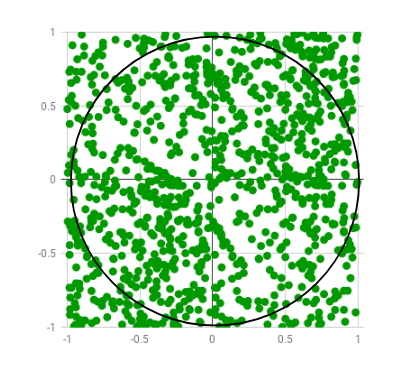

We know that the area of a circle divided by the area of the square is pi/4. For a very large number of generated points: 






Reference: https://www.geeksforgeeks.org/estimating-value-pi-using-monte-carlo/

### Calculating Pi without and with using Dask: Watch for how the Code Is Written

Let's calculate pi without using Dask and see how long it takes for the cpu (pay attention to total cpu time), the user and the wall-clock time.  This is showing why dask code needs to be written correctly.  

In [4]:

##Compute pi without dask

def pi(n):
    
    inside = 0     

    for i in range(n):

        x, y = random(), random()
        if x**2 + y**2 < 1:
            inside += 1
        
    return inside/n*4


In [5]:
%%time
pi(10**7)

CPU times: user 2.68 s, sys: 8.44 ms, total: 2.69 s
Wall time: 2.71 s


3.1409564

### Calculating pi using numpy arrays

Instead of running a loop through to generate n points, we will pivot to generating x and y into arrays using the uniform numpy random function generator 

In [6]:
%%time


n=10**7

x, y  = np.random.uniform(low=-1, high = 1, size = n), np.random.uniform(low=-1, high = 1, size = n)
in_circle = len(x[((x**2+y**2)<1)==True])
in_circle/n*4

CPU times: user 282 ms, sys: 47.7 ms, total: 330 ms
Wall time: 334 ms


3.1412312

Now, lets use those vectors to generate what this would look like on a graph by coloring everything within the circle a different color

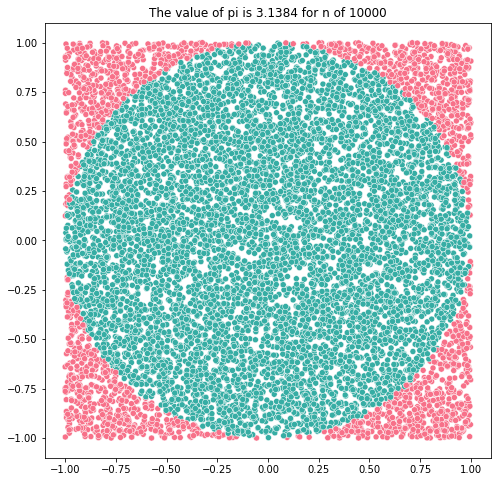

CPU times: user 449 ms, sys: 69.2 ms, total: 518 ms
Wall time: 553 ms


In [7]:
%%time

##Take a look at what one n would look like

n = 10**4


x, y  = np.random.uniform(low=-1, high = 1, size = n), np.random.uniform(low=-1, high = 1, size = n)
in_circle = len(x[((x**2+y**2)<1)==True])
current_pi = in_circle/n*4


plt.figure(figsize = (8,8))
sns.scatterplot(x=x, y=y, hue=(x**2+y**2)<1,  
                palette='husl', legend=False).set(title = f'The value of pi is {current_pi} for n of {n}')
plt.show()



Now lets take a look at different volumes of n and how that impacts how close we get to pi

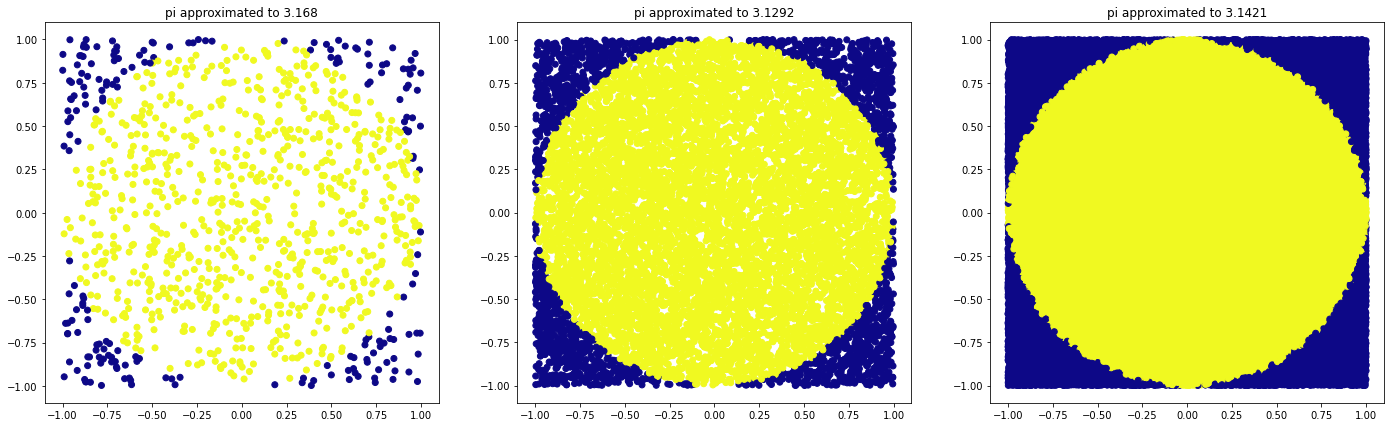

In [8]:
def set_axis(axis , n ):

    n = int(n)
    x, y  = np.random.uniform(low=-1, high = 1, size = n), np.random.uniform(low=-1, high = 1, size = n)
    line = axis.scatter(x, y, c= ((x**2+y**2)<1)==True)
    current_pi = len(x[((x**2+y**2)<1)==True])/n*4
    axis.set_title(f'pi approximated to {round(current_pi,4)}')


fig, [ax , ax1, ax2] = plt.subplots(1, 3)

fig.set_figwidth(24)
fig.set_figheight(7)
plt.set_cmap('plasma')


set_axis(ax, 10**3)
set_axis(ax1, 10**4)
set_axis(ax2, 10**5)
# set_axis(ax3, 10**5)

As the points get more dense, we can see the circle more clearly as well as the value of pi getting closer to 3.141592...

### Calculating Pi Using Dask without Parallelisation

To calculate pi using dask, we can use the decorator function @dask.delayed or just delayed and the compute function to retrieve the output of our pi calculation. We can also use the client function to compute pi.  The delayed function will run tasks in parallel and is especially helpful for custom algorithms.  The client function will run dasks in parallel and distribute them in the cluster.  Although in the example below all of our code runs, and we call the right functions, this is not the most effective way to write code for dask.


*Dask will be looking to spread individual tasks over different workers.* 

Inefficent: If we have one large function, it will send that one large task to one worker. 
Efficent: If we split the calculation into smaller functions, dask will be able to send those smaller tasks to multiple workers and then compile the results at the end. 

Take a close look at the total cpu time and total wall clock time.  The CPU time is at many times less when using Dask, but the wall clock time is the same.  

What do you think is wrong with the code in this procedure?  Why doesn't the wall-clock time improve? Hint: Is Dask creating a 'future calculation' that is performed once the function is actually called?  In otherwords at runtime calculation?

In [9]:

## define function for pi without Dask, same function as defined earlier; 


def pi(n):
    time.sleep(10**-7)
    inside = 0     

    for i in range(n):
        x, y = random(), random()
        if x**2 + y**2 < 1:
            inside += 1
    
        
    return inside/n*4


In [10]:
%%time

#Use the client to execute the original pi function

pi_client = client.submit(pi,10**8)
pi_client = pi_client.result()
print(pi_client)

3.14126092
CPU times: user 20.3 ms, sys: 1.47 ms, total: 21.7 ms
Wall time: 28.8 s


In [11]:
%%time

#Use dask delayed to execute the original pi function with the sleep timer to ensure everything is calculated

pi = delayed(pi)(10**8)
pi.compute()

CPU times: user 20.6 ms, sys: 777 µs, total: 21.4 ms
Wall time: 28.2 s


3.14126092

So we can see above that the fast calculations happen when calling pi with or without Dask (using the delayed or submit methods) with a wall-clock time is about the same.  What's the problem here?  Why isn't Dask making the code run faster?

### Speeding up the calculation of Pi, we need to write the code so it can be parallelized or distributed.

Here we create a function that can be run with only using only 1 term at a time, a iterating over a list and a single calculation (sum function).  
This function of pi will run in parallel on Dask.  You will notice an immediate time improvement.  
You'll notice that a single task is given in the routine which takes in a single term.  
Note: This is not the only way to parallelize a function, but in this case it is effective because it breaks larger tasks into smaller ones that can be run in parallel. In the code below you see how calculate pi in three ways, two of which use Dask.  The methods we show are correct and work:

- without Dask

- with paralellism and using futures (```delay``` function)

- with paralellism and distributed on the cluster (```client``` function)

Which way is fastest?  Why do you think so?  Hint: using the client function will distribute tasks over a cluster.


In [12]:
#Write a pi function that only computes one term at a time vs. earlier where the entire calculation 
# was defined within the function

def pi_single_term(i):
    
    x, y = random(), random()
    if x**2 + y**2 < 1:
        return 1
    else:
        return 0


In [13]:
%%time
## compute pi without Dask, using the new function 
n = 10**8
s = []
for i in range(n):
    s.append(pi_single_term(i))
sum(s)/n*4

CPU times: user 39.7 s, sys: 302 ms, total: 40 s
Wall time: 40.1 s


3.14126092

We can see that it added time to the clock for the same 10^7 we had before

In [14]:
@dask.delayed
def pi_single_term_delayed(i):
    

    x, y = random(), random()
    if x**2 + y**2 < 1:
        return 1
    else:
        return 0

In [15]:
%%time
## compute pi with Dask using Delayed
n = 10**5
s = []
for i in range(n):
    s.append(pi_single_term_delayed(i))
dask.delayed(sum)(s).compute()/n*4


/opt/conda/lib/python3.8/site-packages/distributed/worker.py:3871: UserWarning: Large object of size 5.91 MiB detected in task graph: 
  (['pi_single_term_delayed-8fe67ef7-3ba8-4ece-9105- ... 5af32750eca'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 7.12 s, sys: 847 ms, total: 7.96 s
Wall time: 49.7 s


3.1426

If we look at the Dask Web UI while this is executing, we can see that instead of having one big calculation pi, we now have many single pi term calculations and a single sum task after those complete. We see the time increasing from 3 seconds for 10^7 to 42 seconds for just 10^5 because of the scheduling

In [16]:
%%time

n = 10**5


mapped = client.map(pi_single_term, range(n)) #, batch_size=10**6)
client.submit(sum, mapped).result()/n*4

CPU times: user 11.1 s, sys: 633 ms, total: 11.7 s
Wall time: 50.3 s


3.14248

You'll notice watching the UI that for about half the time (20 seconds) the time nothing is executing and that is because the tasks are being scheduled which takes 

### Importance of appropriate sized tasks

What if we break down the problem again, but instead this time being a bit more conscious about how many tasks we are creating? 

In [17]:
def pi_inside(n):
#     time.sleep(10**-7)
    inside = 0     

    for i in range(n):
        x, y = random(), random()
        if x**2 + y**2 < 1:
            inside += 1
    
        
    return inside



In [18]:
client.restart()

<Client: 'tcp://10.0.43.33:8786' processes=0 threads=0, memory=0 B>

In [19]:
%%time

client.restart()
pi_client = []
n = 10**8
target_size = 10**7 #because this takes about 1 second each and is a manageable 'chunk size' of work
chunks = int(n/target_size)

for i in range(chunks):
    pi_client.append(client.submit(pi_inside,int(n/chunks), pure=False))


client.submit(sum, pi_client).result()/n*4

CPU times: user 14.1 ms, sys: 4.22 ms, total: 18.3 ms
Wall time: 12.4 s


3.14203036

We now see a major increase in speed and the tasks parallelized efficently 

### Back to arrays, this time using dask arrays

We will now use the same methodology as we did with numpy arrays, you will notice the syntax is very similar. To show the advantage of parallelization, we will increase the data load 

Using dask is faster when dataloads are higher, but when the scale is smaller its best to stick with numpy

In [20]:
%%time

##For reference the numpy calculation

# n=10**9 # this takes very long to run 
n=10**8

x, y = np.random.uniform(low=-1, high = 1, size = n), np.random.uniform(low=-1, high = 1, size = n)

in_circle = len(x[((x**2+y**2)<1)==True])
in_circle/n*4

CPU times: user 2.5 s, sys: 707 ms, total: 3.21 s
Wall time: 3.21 s


3.1416468

In [21]:
%%time
# Use of Dask Array in place of numpy, we will use the compute chunk sizes function to parallelize the count of 
# of points inside the circle

n=10**8

x, y  = da.random.uniform(low=-1, high = 1, size = n), da.random.uniform(low=-1, high = 1, size = n)
in_circle = x[((x**2+y**2)<1)==True]
in_circle.compute_chunk_sizes()
in_circle.shape[0]/n*4

CPU times: user 19.6 ms, sys: 3.79 ms, total: 23.4 ms
Wall time: 702 ms


3.14157868

In [38]:
%%time

pi_list = {}
for i in np.linspace(1,9,50):

    n=int(10**i)

    x, y  = da.random.uniform(low=-1, high = 1, size = n), da.random.uniform(low=-1, high = 1, size = n)
    in_circle = x[((x**2+y**2)<1)==True]

    in_circle.compute_chunk_sizes()

    pi_list[i] = in_circle.shape[0]/n*4

CPU times: user 673 ms, sys: 35.2 ms, total: 708 ms
Wall time: 15.4 s


Text(0.5, 0, 'Number of points 10^')

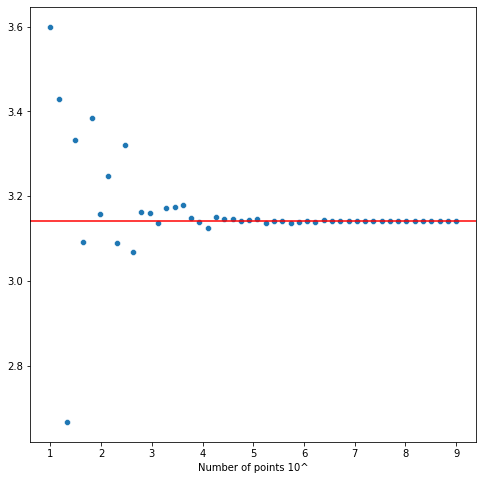

In [39]:
plt.figure(figsize = (8,8))

graph = sns.scatterplot(data = pi_list, y=pi_list.values(), x=pi_list.keys() )

pi = graph.axhline(math.pi, c='r')
graph.axes.set_xlabel('Number of points 10^')
graph.axes.set_ylabel('Pi a')


In [24]:
client.restart()

<Client: 'tcp://10.0.43.33:8786' processes=0 threads=0, memory=0 B>

Great job!